<a href="https://colab.research.google.com/github/amirhoseinaghaei/Research_Simulation/blob/main/Research_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!fusermount -u drive
!google-drive-ocamlfuse drive

fusermount: failed to unmount /content/drive: No such file or directory
/bin/bash: google-drive-ocamlfuse: command not found


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/') 

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
%cd gdrive/MyDrive/Research_Simmulation/


/content/gdrive/MyDrive/Research_Simmulation


In [4]:

import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750
deadline = 50
Lesson_buffer_a0 = LessonBuffer(1000, deadline, 5)
episode = 0
rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=500,
                        lstm_batch_size=32, continuous_pred_factor=0.5)
rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_500_send_0.2.pt'))
environment = Environment(1000,100)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(5000)):
    episode += 1
    environment.reset_paramter()
    state, _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    rewards = []
    states = [state]
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'
# if policy_updator.Quality[name,0] > policy_updator.Quality[name,1] else 1
    while not done:
        action = 1
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.U > 0:
            action = 0
        if environment.sendbackaction == True:
            action = 1

        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if rewards[-1] == 0 and len(res) > 0 :
              rewards[-1] = sum(rewards)
              rewards[-1] = rewards[-1]
              rewards[res[0]] = 0
            else:
              rewards[-1] = rewards[-1]
               
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)

            # Lesson_buffer_a0.add(states = states, actions = actions, rewards = rewards)
            # if  episode < 2500 and Lesson_buffer_a0.full_enough() and Lesson_buffer_a0.different_returns_encountered()  :
            #         if episode % 25 == 0:

            #             print(episode)
            #             rudder_lstm_a0.train(episode=episode)
            #         if episode >= 500: 
            #             torch.save(rudder_lstm_a0.state_dict(), 'rudder_lstm_500_send_0.2.pt')

            rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

Optimal_Policy_Dict = {}
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
          
         if keys[0] in initial_StateName: 
            print('{:15} {:15} {:15}'.format( keys[0] , keys[1] , policy_updator.Quality[keys[0] ,keys[1]]))
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              Optimal_Policy_Dict[keys[0]] = "wait"
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              Optimal_Policy_Dict[keys[0]] = "send"
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))
print(Optimal_Policy_Dict)

[[0.2, 0.8], [0.30000000000000004, 0.7]]
[[0.2, 0.8], [0.30000000000000004, 0.7]]
433992


100%|██████████| 5000/5000 [01:15<00:00, 66.33it/s]


(22, Ch1, 500, 1, 0)               0               0
(22, Ch1, 500, 1, 0) Wait                          0
(22, Ch1, 500, 1, 0)               1 -843.999267578125
(22, Ch1, 500, 1, 0) Wait                          0
(22, Ch2, 500, 1, 0)               0               0
(22, Ch2, 500, 1, 0) Wait                          0
(22, Ch2, 500, 1, 0)               1 -1154.268798828125
(22, Ch2, 500, 1, 0) Wait                          0
(26, Ch1, 500, 1, 0)               0               0
(26, Ch1, 500, 1, 0) Wait                          0
(26, Ch1, 500, 1, 0)               1 -652.522705078125
(26, Ch1, 500, 1, 0) Wait                          0
(26, Ch2, 500, 1, 0)               0               0
(26, Ch2, 500, 1, 0) Wait                          0
(26, Ch2, 500, 1, 0)               1 -890.3140869140625
(26, Ch2, 500, 1, 0) Wait                          0
(30, Ch1, 500, 1, 0)               0               0
(30, Ch1, 500, 1, 0) Wait                          0
(30, Ch1, 500, 1, 0)               1

In [ ]:
import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

Lesson_buffer_a1 = LessonBuffer(1000, 25, 5)
episode = 0

rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
# rudder_lstm.load_state_dict(torch.load('rudder_lstm.pt'))
environment = Environment(100,25)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
visited_dict_0 = {}
for i in range(5000):
    episode += 1
    environment.reset_paramter()
    state = environment.reset_state()
    rewards = []
    states = [state]
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    while not done:
        action = 1 
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.Ra == 0 and environment.state.U == 24:
            action = 1
        if environment.state.U > 0:
            action = 0
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              # print(res)
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            Lesson_buffer_a1.add(states = states, actions = actions, rewards = rewards)
            if  episode < 2000 and Lesson_buffer_a1.full_enough() and Lesson_buffer_a1.different_returns_encountered()  :
                    if episode % 25 == 0:

                        # print("True")
                        print(episode)
                        rudder_lstm_a1.train(episode=episode)
                    if episode >= 1800: 
                        torch.save(rudder_lstm_a1.state_dict(), 'rudder_lstm_send_100.pt')
            rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            print('{:15} {:15} {:15}'.format( keys[0] ,  keys[1], value))
print("******************************************************************")
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))


In [ ]:



import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm 

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

episode = 0
Lesson_buffer_a1 = LessonBuffer(1000, 50, 5)
Lesson_buffer_a0 = LessonBuffer(1000, 50, 5)

rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_500_wait_0.2.pt'))
rudder_lstm_a1.load_state_dict(torch.load('rudder_lstm_500_send_0.2.pt'))

environment = Environment(1000,100)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(8000)):
    episode += 1
    environment.reset_paramter()
    state , _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    rewards = []
    states = [state]
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    while not done:
        if np.random.random() < 0.15:
            action = np.random.choice(2) 
        else:
            action = 0 if policy_updator.Quality[name,0] > policy_updator.Quality[name,1] else 1
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.U > 0:
            action = 0
        if environment.sendbackaction == True:
            action = 1
        state, reward, done = environment.step(action)
    
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              # print(res)
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            if actions[0] == 0: 
              rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            if actions[0] == 1: 
              rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
              # for i in range(len(rewards)):
              #   rewards[i] = 0
              # print(rewards)
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

Optimal_Policy_Dict = {}
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              Optimal_Policy_Dict[keys[0]] = "wait"
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              Optimal_Policy_Dict[keys[0]] = "send"
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))
print(Optimal_Policy_Dict)

[[0.2, 0.8], [0.30000000000000004, 0.7]]
433992


  2%|▏         | 158/8000 [00:05<04:01, 32.49it/s]

 **Finding Optimal policies with DQN** 

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        # if T.cuda.is_available() else 'cpu'
        self.device = T.device('cuda')
        self.to(self.device)

    def forward(self, state):
        state = T.Tensor(state).to(self.device)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions,
                                   input_dims=input_dims,
                                   fc1_dims=256, fc2_dims=256)
        self.state_memory = np.zeros((self.mem_size, *input_dims),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            # state = T.tensor(observation).to(self.Q_eval.device)      
            actions = self.Q_eval.forward(observation)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        # print((q_next)[:,0])
        # print(T.max(q_next, dim=1)[0])
        # print((q_next)[:,0])
        # Time.sleep(1)
        q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min

In [ ]:
import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm
lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

episode = 0

Lesson_buffer_a1 = LessonBuffer(1000, 40, 5)
Lesson_buffer_a0 = LessonBuffer(1000, 40, 5)

rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_70_125_wait_0.2.pt'))
rudder_lstm_a1.load_state_dict(torch.load('rudder_lstm_70_125_send_0.2.pt'))


DQN_Agent = Agent(gamma=1, epsilon=1.0, batch_size=64, n_actions=2, eps_end=0.01,
                  input_dims=[5], lr=0.001)

environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(8000)):
    # print(episode)
    episode += 1
    environment.reset_paramter()
    state, _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])

    rewards = []
    states = [state]
    actions = []
    dones = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'
    # prev_state = state

    initial_state= state
    if initial_state[1] == "Ch1":
        initial_state[1] = 1
    else:
        initial_state[1] = 0
    initial_state = initial_state.astype(int)

    while not done:
   
        action = DQN_Agent.choose_action(initial_state)
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.Ra == 0 and environment.state.U == 24:
            action = 1
        if environment.state.U > 0:
            action = 0
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        dones.append(done)
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              # print(res)
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            if actions[0] == 0: 
              rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            if actions[0] == 1: 
              rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            for i in range(25):
              DQN_Agent.store_transition(states[i], actions[i], rewards[i], states[i+1],
                                  dones[i])
              DQN_Agent.learn()
Optimal_Policy_Dict = {}
for state in environment.initial_State:
  State  =  np.array([state.Au, state.Ch, state.BT, state.Ra, state.U])
  if State[1] == "Ch1":
    State[1] = 1
  else:
    State[1] = 0
  State = State.astype(int) 
  actions =  DQN_Agent.Q_eval.forward(State)

  if State[1] == 1:
    CH_NAME = "Ch1"
  else:
    CH_NAME = "Ch2"
  name = f'({State[0]}, {CH_NAME}, {State[2]}, {State[3]}, {State[4]})'
  action = T.argmax(actions).item()
  if action == 0:
    Optimal_Policy_Dict[name] = "wait"
  else:
    Optimal_Policy_Dict[name] = "send"  
  print(f'{State} ___________________________ {DQN_Agent.Q_eval.forward(State)}')
print(Optimal_Policy_Dict)


**optimal policies with Dueling Double DQN** 

In [ ]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ReplayBuffer():
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                    dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

class DuelingDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        super(DuelingDeepQNetwork, self).__init__()
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        self.fc1 = nn.Linear(*input_dims, 512)
        self.V = nn.Linear(512, 1)
        self.A = nn.Linear(512, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        # 
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        flat1 = F.relu(self.fc1(state))
        V = self.V(flat1)
        A = self.A(flat1)

        return V, A

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

class Dueling_DDQN_Agent():
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, chkpt_dir='tmp/dueling_ddqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(self.n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims)

        self.q_eval = DuelingDeepQNetwork(self.lr, self.n_actions,
                                   input_dims=self.input_dims,
                                   name='lunar_lander_dueling_ddqn_q_eval',
                                   chkpt_dir=self.chkpt_dir)

        self.q_next = DuelingDeepQNetwork(self.lr, self.n_actions,
                                   input_dims=self.input_dims,
                                   name='lunar_lander_dueling_ddqn_q_next',
                                   chkpt_dir=self.chkpt_dir)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
            _, advantage = self.q_eval.forward(state)
            action = T.argmax(advantage).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                        if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        indices = np.arange(self.batch_size)

        V_s, A_s = self.q_eval.forward(states)
        V_s_, A_s_ = self.q_next.forward(states_)

        V_s_eval, A_s_eval = self.q_eval.forward(states_)

        q_pred = T.add(V_s,
                        (A_s - A_s.mean(dim=1, keepdim=True)))[indices, actions]
        q_next = T.add(V_s_,
                        (A_s_ - A_s_.mean(dim=1, keepdim=True)))

        q_eval = T.add(V_s_eval, (A_s_eval - A_s_eval.mean(dim=1,keepdim=True)))

        max_actions = T.argmax(q_eval, dim=1)
        max_actions[indices] = 0
        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next[indices, max_actions]

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

In [ ]:

import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from tqdm import tqdm
lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

episode = 0
Lesson_buffer_a1 = LessonBuffer(1000, 25, 5)
Lesson_buffer_a0 = LessonBuffer(1000, 25, 5)

rudder_lstm_a0 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a0, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a1 = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer_a1, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
rudder_lstm_a0.load_state_dict(torch.load('rudder_lstm_150_wait_0.45.pt'))
rudder_lstm_a1.load_state_dict(torch.load('rudder_lstm_150_send_0.45.pt'))


Dueling_Double_DQN_Agent = Dueling_DDQN_Agent(gamma=1, epsilon=1.0, lr=3e-4,
                  input_dims=[5], n_actions=2, mem_size=100000, eps_min=0.01,
                  batch_size=64, eps_dec=1e-3, replace=100)

environment = Environment(250,50)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in tqdm(range(5000)):
    episode += 1
    environment.reset_paramter()
    state, _ = environment.reset_state()
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    rewards = []
    states = [state]
    actions = []
    dones = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    initial_state= state
    if initial_state[1] == "Ch1":
        initial_state[1] = 1
    else:
        initial_state[1] = 0
    initial_state = initial_state.astype(int)

    while not done:
        action = Dueling_Double_DQN_Agent.choose_action(initial_state)
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        # if environment.state.Ra == 0 and environment.state.U == 19:
        #     action = 1
        if environment.state.U > 0:
            action = 0
        if environment.sendbackaction == True:
           action = 1
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        dones.append(done)
        if done: 
            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              rewards[-1] = rewards[res[0]]
              rewards[-1] = rewards[-1]/20
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            if actions[0] == 0: 
                  rewards = rudder_lstm_a0.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            if actions[0] == 1: 
                  rewards = rudder_lstm_a1.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            for i in range(25):
              Dueling_Double_DQN_Agent.store_transition(states[i], actions[i], rewards[i], states[i+1],
                                  dones[i])
              Dueling_Double_DQN_Agent.learn()
Optimal_Policy_Dict = {}
for state in environment.initial_State:
  print(state.Name)
  State  =  np.array([state.Au, state.Ch, state.BT, state.Ra, state.U])
  if State[1] == "Ch1":
    State[1] = 1
  else:
    State[1] = 0
  State = State.astype(int) 
  state = T.tensor([State],dtype=T.float).to(Dueling_Double_DQN_Agent.q_eval.device)
  _, advantage =  Dueling_Double_DQN_Agent.q_eval.forward(state)
  action = T.argmax(advantage).item()
  if State[1] == 1:
    CH_NAME = "Ch1"
  else:
    CH_NAME = "Ch2"
  name = f'({State[0]}, {CH_NAME}, {State[2]}, {State[3]}, {State[4]})'
  if action == 0:
    Optimal_Policy_Dict[name] = "wait"
  else:
    Optimal_Policy_Dict[name] = "send"  
  print(f'{State} __________________ {advantage}_________________{action}')
print(Optimal_Policy_Dict)

[[0.45, 0.55], [0.55, 0.44999999999999996]]
62640


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-10-1b663948e460>:163: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1646.)
  q_next[dones] = 0.0
100%|██████████| 5000/5000 [11:23<00:00,  7.31it/s]


(11, Ch1, 150, 1, 0)
[ 11   1 150   1   0] __________________ tensor([[ -1.9994, -10.9248]], grad_fn=<AddmmBackward0>)_________________0
(11, Ch2, 150, 1, 0)
[ 11   0 150   1   0] __________________ tensor([[  0.6746, -13.7761]], grad_fn=<AddmmBackward0>)_________________0
(15, Ch1, 150, 1, 0)
[ 15   1 150   1   0] __________________ tensor([[ -0.5630, -11.9680]], grad_fn=<AddmmBackward0>)_________________0
(15, Ch2, 150, 1, 0)
[ 15   0 150   1   0] __________________ tensor([[  2.3028, -15.0971]], grad_fn=<AddmmBackward0>)_________________0
(33, Ch1, 150, 1, 0)
[ 33   1 150   1   0] __________________ tensor([[  7.4373, -18.4748]], grad_fn=<AddmmBackward0>)_________________0
(33, Ch2, 150, 1, 0)
[ 33   0 150   1   0] __________________ tensor([[  6.8620, -18.0941]], grad_fn=<AddmmBackward0>)_________________0
(37, Ch1, 150, 1, 0)
[ 37   1 150   1   0] __________________ tensor([[  7.8964, -18.6970]], grad_fn=<AddmmBackward0>)_________________0
(37, Ch2, 150, 1, 0)
[ 37   0 150   1   0

In [ ]:



import numpy as np
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater

lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750

Lesson_buffer = LessonBuffer(1000, 25, 5)
episode = 0
rudder_lstm = LSTM(state_input_size=5, n_actions= 2, buffer=Lesson_buffer, n_units=n_lstm,
                        lstm_lr=lstm_lr, l2_regularization=l2_regularization, return_scaling=10,
                        lstm_batch_size=8, continuous_pred_factor=0.5)
# rudder_lstm.load_state_dict(torch.load('rudder_lstm.pt'))
environment = Environment(100,25)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
episode = 0
for i in range(2050):
    episode += 1
    environment.reset_paramter()
    state = environment.reset_state()
    rewards = []
    states = [state]
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    actions = []
    done = False
    name = f'({state[0]}, {state[1]}, {state[2]}, {state[3]}, {state[4]})'

    while not done:
        action = 0 if policy_updator.Quality[name,0] > policy_updator.Quality[name,1] else 1
        if environment.state.Ra == 0 and environment.state.U == 0:
            action = 0
        if environment.state.Ra == 0 and environment.state.U == 24:
            action = 1
        if environment.state.U > 0:
            action = 0
        state, reward, done = environment.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 

            res = np.nonzero(rewards)[0]
            if len(res) > 0 :
              rewards[-1] = rewards[res[0]]
              rewards[res[0]] = 0   
            for i in states: 
                if i[1] == "Ch1":
                    i[1] = 1
                else:
                    i[1] = 0
            states = np.stack(states)
            states = states.astype(int)
            rewards = np.array(rewards, dtype = np.float32)
            actions = np.array(actions)
            Lesson_buffer.add(states = states, actions = actions, rewards = rewards)
            if  episode < 5000 and Lesson_buffer.full_enough() and Lesson_buffer.different_returns_encountered()  :
                    if episode % 25 == 0:

                        print(episode)
                        rudder_lstm.train(episode=episode)
                    if episode >= 1800: 
                        torch.save(rudder_lstm.state_dict(), 'rudder_lstm_120.pt')

            rewards = rudder_lstm.redistribute_reward(states=np.expand_dims(states, 0),actions=np.expand_dims(actions, 0))[0, :]
            policy_updator.Q_learning(actions= actions , states = states, rewards= rewards)

for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            print('{:15} {:15} {:15}'.format( keys[0] ,  keys[1], value))

print("******************************************************************")
Optimal_Policy_Dict = {}
for keys, value in policy_updator.Quality.items():
         initial_StateName = []
         for i in environment.initial_State:
            initial_StateName.append(i.Name) 
         if keys[0] in initial_StateName: 
            if policy_updator.Quality[keys[0],0] > policy_updator.Quality[keys[0],1]:  
              Optimal_Policy_Dict[keys[0]] = "wait"
              print('{:15} {:15} {:15}'.format( keys[0] , "Wait" , policy_updator.Quality[keys[0] ,0]))
            else:
              Optimal_Policy_Dict[keys[0]] = "send"
              print('{:15} {:15} {:15}'.format( keys[0] , "Send Back" , policy_updator.Quality[keys[0] ,1]))
print(Optimal_Policy_Dict)

In [ ]:
!pip install PyQt5


In [4]:
import json
 
# Opening JSON file
with open('Optimal_Policy_Qlearning_0.2_500.json') as json_file:
    Optimal_Policy_Dict_Qlearning = json.load(json_file)
with open('Optimal_Policy_DictDDDQN_0.9_500.json') as json_file:
    Optimal_Policy_Dict_DDDQN = json.load(json_file)

In [5]:
import json
with open("Optimal_Policy_Qlearning_0.2_500.json", "w") as write_file:
    json.dump(Optimal_Policy_Dict, write_file, indent=4)

[[0.9, 0.09999999999999998], [1.0, 0.0]]
[[0.9, 0.09999999999999998], [1.0, 0.0]]
433992
['90' 'Ch2' '500' '1' '0']
['326' 'Ch2' '500' '1' '0']
['126' 'Ch1' '500' '1' '0']
['306' 'Ch2' '500' '1' '0']
['146' 'Ch1' '500' '1' '0']
['254' 'Ch1' '500' '1' '0']
['322' 'Ch1' '500' '1' '0']
['314' 'Ch1' '500' '1' '0']
['246' 'Ch1' '500' '1' '0']
['246' 'Ch1' '500' '1' '0']
['130' 'Ch1' '500' '1' '0']
['78' 'Ch1' '500' '1' '0']
['190' 'Ch2' '500' '1' '0']
['138' 'Ch2' '500' '1' '0']
['322' 'Ch2' '500' '1' '0']
['190' 'Ch2' '500' '1' '0']
['322' 'Ch1' '500' '1' '0']
['270' 'Ch2' '500' '1' '0']
['22' 'Ch2' '500' '1' '0']
['190' 'Ch2' '500' '1' '0']
['90' 'Ch1' '500' '1' '0']
['306' 'Ch1' '500' '1' '0']
['270' 'Ch2' '500' '1' '0']
['198' 'Ch1' '500' '1' '0']
['22' 'Ch1' '500' '1' '0']
['330' 'Ch2' '500' '1' '0']
['262' 'Ch1' '500' '1' '0']
['198' 'Ch2' '500' '1' '0']
['186' 'Ch1' '500' '1' '0']
['78' 'Ch1' '500' '1' '0']
['318' 'Ch2' '500' '1' '0']
['30' 'Ch1' '500' '1' '0']
['314' 'Ch1' '500' '1'

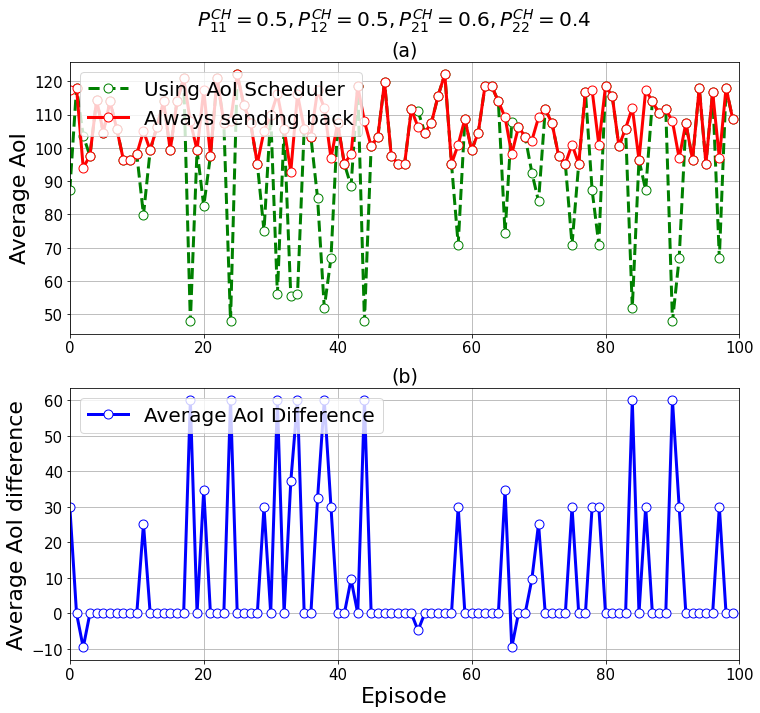

In [5]:
import numpy as np
# from Environment import Actor
from Rudder import LessonBuffer
from Environment import Environment
from Rudder import RRLSTM as LSTM
import torch
import time as Time
import random
from PolicyUpdater import PolicyUpdater
from matplotlib import pyplot as plt
from StateDto import State


lb_size = 2048
n_lstm = 16
max_time = 50
policy_lr = 0.5
lstm_lr = 1e-2
l2_regularization = 1e-6
avg_window = 750
UseOptimalPolicy = True
episode = 0
NUM_EPISODE = 100
deadline = 50
environment = Environment(1000,100)
environment.CreateStates()
policy_updator  = PolicyUpdater(environment= environment, lr = policy_lr)
Total_Reward_List = []
Total_Reward_List_Without_Optimal_Policy = []

for i in range(NUM_EPISODE):
    environment.reset_paramter()
    state , fixed_State = environment.reset_state()
    first_state = state
    print(first_state)
    environment.generate_channel_state_list_for_whole_sequence(state[1])
    episode += 1
    rewards = []
    states = [first_state]
    Episode_AoI = [first_state[0]]
    actions = []
    done = False
    name = f'({first_state[0]}, {first_state[1]}, {first_state[2]}, {first_state[3]}, {first_state[4]})'

    while not done:
        # action  = 0 if Optimal_Policy_Dict_Qlearning[name] == 'wait' else 1
        action = 1 
        if environment.state.Ra == 0 and environment.state.U == 0:
          action = 0
        if environment.state.U > 0:
          action = 0
        if environment.sendbackaction == True:
          action = 1
        state, reward, done = environment.step(action)
        Episode_AoI.append(state[0])
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 
          Episode_AoI = [int(i) for i in Episode_AoI]
          Total_Reward_List_Without_Optimal_Policy.append(sum(Episode_AoI)/deadline)
    rewards = []
    states = [first_state]
    Episode_AoI = [first_state[0]]
    actions = []
    done = False
    environment.reset_paramter()
    environment.state = State(name, int(first_state[0]), (first_state[1]), int(first_state[2]), int(first_state[3]), int(first_state[4]))
    while not done:
        if UseOptimalPolicy:
          action  = 0 if Optimal_Policy_Dict_DDDQN[name] == 'wait' else 1 
          # print(Optimal_Policy_Dict[name])
        # else:
        #   action = 1 
        if environment.state.Ra == 0 and environment.state.U == 0:
          action = 0
        # if environment.state.Ra == 0 and environment.state.U == 24:
        #   action = 1
        if environment.state.U > 0:
          action = 0
        if environment.sendbackaction == True:
          action = 1
        state, reward, done = environment.step(action)

        Episode_AoI.append(state[0])
        actions.append(action)
        states.append(state)
        rewards.append(reward) 
        if done: 
          Episode_AoI = [int(i) for i in Episode_AoI]
          Total_Reward_List.append(sum(Episode_AoI)/deadline)


fig, ax = plt.subplots(2,figsize=(12,11))


AVerageAoIUsingScheduler = [sum(Total_Reward_List)/NUM_EPISODE for i in range(NUM_EPISODE)]
AVerageAoIWithoutScheduler = [sum(Total_Reward_List_Without_Optimal_Policy)/NUM_EPISODE for i in range(NUM_EPISODE)]

AoI_Difference_List = [Total_Reward_List_Without_Optimal_Policy[i] - Total_Reward_List[i] for i in range(len(Total_Reward_List_Without_Optimal_Policy)) ]

ax[1].plot(AoI_Difference_List, label ='Average AoI Difference', color = "b" ,mec = 'b', mfc = 'w', marker='.', markersize = 18, linestyle = "solid", linewidth = 3)

ax[0].plot(Total_Reward_List, label ='Using AoI Scheduler', color = "g" ,mec = 'g', mfc = 'w', marker='.', markersize = 18, linestyle = "dashed", linewidth = 3)
ax[0].plot(Total_Reward_List_Without_Optimal_Policy, label ='Always sending back' , mec = 'r', mfc = 'w', color = "r", marker='.', markersize = 18,  linestyle = "solid", linewidth = 3)
# for i in range(len(Total_Reward_List)):
#     if AoI_Difference_List[i] == 0:
#         color = 'black'  # set the marker color to red if the values are equal
#         ax[1].plot(i, AoI_Difference_List[i], label ='Send decision', color=color, marker='o', markersize=5)
# for i in range(len(Total_Reward_List)):
#     if AoI_Difference_List[i] != 0:
#         color = 'yellow'  # set the marker color to red if the values are equal
#         ax[1].plot(i, AoI_Difference_List[i], label ='Wait decision', color=color, marker='o', markersize=5)


# ax.plot(AVerageAoIUsingScheduler, label ='Average AoI of 100 Episodes Using AoI Scheduler', color = "g" , markersize = 5, linestyle = "dashed", linewidth = 3)
# ax.plot(AVerageAoIWithoutScheduler, label ='Average AoI of 100 Episodes without AoI Scheduler' , color = "r", markersize = 5,  linestyle = "dashed", linewidth = 3)

ax[0].legend(fontsize = 20, loc='upper left')
ax[1].legend(fontsize = 20, loc='upper left')
handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax[1].legend(by_label.values(), by_label.keys(), loc='upper left')

ax[0].grid()
ax[1].grid()
ax[0].set_ylabel("Average AoI", fontsize = 22.0)
ax[0].set_xlim(xmin=0, xmax=NUM_EPISODE)
ax[1].set_xlabel("Episode", fontsize = 22.0)
ax[1].set_ylabel("Average AoI difference", fontsize = 22.0)
ax[1].set_xlim(xmin=0, xmax=NUM_EPISODE)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
string = "$P^{CH}_{11}$$ = 0.5, $$P^{CH}_{12}$$ = 0.5, $$P^{CH}_{21}$$ = 0.6, $$P^{CH}_{22}$$ = 0.4$"
fig.suptitle(string, fontweight ="bold" , y = 0.95, fontsize = 20) 
ax[0].set_title('(a)' , fontsize = 19)
ax[1].set_title('(b)', fontsize = 19)
fig.savefig('SimulationResult_DDDQN_70_125_0.5_0.5.pdf')  

print(f"Average AoI of each episode with AoI scheduler: {sum(Total_Reward_List)/NUM_EPISODE}")
print(f"Average AoI of each episode when DT always send DT data back at request arrival: {sum(Total_Reward_List_Without_Optimal_Policy)/NUM_EPISODE}")
print(f"Average AoI diiference: {sum(AoI_Difference_List)/NUM_EPISODE}")

number_of_optimal_actions = 0
number_of_non_optimal_actions = 0

for i in AoI_Difference_List:
  if i < 0:
      number_of_non_optimal_actions += 1 
  if i > 0:
      number_of_optimal_actions += 1 
print(f"Percenage of optimal actions is {(number_of_optimal_actions/len(AoI_Difference_List))*100}")
print(f"Percenage of non optimal actions is {(number_of_non_optimal_actions/len(AoI_Difference_List))*100}")


In [ ]:
!nvcc --version


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git


In [ ]:
%load_ext nvcc_plugin
